In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from scipy.stats import sem, norm, mannwhitneyu, bootstrap
from my_utils import *
from sklearn.linear_model import RidgeCV

from pathlib import Path
import sys
import warnings
import pickle

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

In [3]:
# agents checkpoints path
progress_agents_path = Path('../data/agents')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure2')
# analysis data path
analysis_data_path = Path('../data/analysis_data/figure2')

# Select agent checkpoints for analyses

In [4]:
Models = {'Holistic_Actor': 'Actor1', 'Holistic_Critic': 'Critic1',
          'Modular_Actor': 'Actor3', 'Modular_Critic': 'Critic5'}
for k, v in Models.items():
    exec(f'from {v} import {v[:-1]} as {k}')

modular_agent_arch = Models['Modular_Actor'] + Models['Modular_Critic']
holistic_agent_arch = Models['Holistic_Actor'] + Models['Holistic_Critic']
moho_agent_arch = Models['Modular_Actor'] + Models['Holistic_Critic']
homo_agent_arch = Models['Holistic_Actor'] + Models['Modular_Critic']
EKF_agent_arch = 'EKF'

MAX_TRAINING_T = 1e4

In [5]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'): 
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.task == 'gain1x')
                                        & (perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.sort_values('reward_rate').iloc[-1].episode
            
            agent_path.append(progress_agents_path / agent_arch / task.split('_')[0] / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    return agent_paths[0], agent_files[0]

In [6]:
def select_agents_all_control(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / f'{task}_control' / '0.1_0.2').glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / f'{task}_control' / '0.1_0.2' / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.task == 'gain1x')
                                        & (perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.sort_values('reward_rate').iloc[-1].episode
            
            agent_path.append(progress_agents_path / agent_arch / 'gain_control' / '0.1_0.2' / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    return agent_paths[0], agent_files[0]

In [7]:
def select_agents_all_holistic_control(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain', noise='0.4_0.1'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / f'{task}_control' / noise).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / f'{task}_control' / noise / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.task == 'gain1x')
                                        & (perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.sort_values('reward_rate').iloc[-1].episode
            
            agent_path.append(progress_agents_path / agent_arch / 'gain_control' / noise / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    return agent_paths[0], agent_files[0]

In [8]:
modular_agent_paths, modular_agent_files = select_agents_all(progress_agents_path, 
                                                             [modular_agent_arch], MAX_TRAINING_T, task='gain')
holistic_agent_paths, holistic_agent_files = select_agents_all(progress_agents_path, 
                                                               [holistic_agent_arch], MAX_TRAINING_T, task='gain')
moho_agent_paths, moho_agent_files = select_agents_all(progress_agents_path, 
                                                       [moho_agent_arch], MAX_TRAINING_T, task='gain')
homo_agent_paths, homo_agent_files = select_agents_all(progress_agents_path, 
                                                       [homo_agent_arch], MAX_TRAINING_T, task='gain')
EKF_agent_paths, EKF_agent_files = select_agents_all(progress_agents_path, 
                                                     [EKF_agent_arch], MAX_TRAINING_T, task='gain')

In [9]:
modular_agent_control_paths, modular_agent_control_files = select_agents_all_control(progress_agents_path, 
                                                                     [modular_agent_arch], MAX_TRAINING_T, task='gain')
EKF_agent_control_paths, EKF_agent_control_files = select_agents_all_control(progress_agents_path, 
                                                                     [EKF_agent_arch], MAX_TRAINING_T, task='gain')

In [10]:
holistic_agent_control_paths, holistic_agent_control_files = select_agents_all_holistic_control(progress_agents_path, 
                                                                     [holistic_agent_arch], MAX_TRAINING_T, noise='0.4_0.1')

In [11]:
holistic_agent_long_paths, holistic_agent_long_files = select_agents_all(Path('../data/agents_all'), 
                                                               [holistic_agent_arch], MAX_TRAINING_T=1e5, task='gain_full')

# Run agents

In [12]:
from Environment import Env
from Agent_RNN import *

In [14]:
def RNN_agent_simulation(agent, target_positions, arg):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []; 
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range
    
    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps,
                                 state=state_, action=action_))

In [15]:
SAMPLE_SIZE = 2000

reset_seeds(0)
arg = config.ConfigGain()
arg.device = 'cpu'
env = Env(arg)
target_positions = []

for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    target_positions.append(env.target_position)

In [16]:
pro_stds = [str(i) for i in [0.2, 0.4, 0.6, 0.8, 1]]; obs_stds = [str(i) for i in [0.1, 0.3, 0.5, 0.7, 0.9]]
agent_noises = ['_'.join(list(i)) for i in cartesian_prod(pro_stds, obs_stds)]
agent_noises_rev = ['_'.join(list(i)) for i in cartesian_prod(obs_stds, pro_stds)]

## Running the following cells takes a lot of time, so I've saved the results. We can now simply load those results for analysis.

In [ ]:
'''
modular_agents = []; modular_agent_trajectories = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(modular_agent_paths, modular_agent_files):
        agent = Agent(arg, Modular_Actor, Modular_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    modular_agents.append(agents_)
    modular_agent_trajectories.append(agent_trajectories_)
'''

In [21]:
'''
modular_agents_control = []; modular_agent_trajectories_control = []
for idx, agent_noise in enumerate(agent_noises_rev):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(modular_agent_control_paths, modular_agent_control_files):
        agent = Agent(arg, Modular_Actor, Modular_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    modular_agents_control.append(agents_)
    modular_agent_trajectories_control.append(agent_trajectories_)
'''

In [24]:
'''
holistic_agents = []; holistic_agent_trajectories = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(holistic_agent_paths, holistic_agent_files):
        agent = Agent(arg, Holistic_Actor, Holistic_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    holistic_agents.append(agents_)
    holistic_agent_trajectories.append(agent_trajectories_)
'''

In [25]:
'''
holistic_agents_control = []; holistic_agent_trajectories_control = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(holistic_agent_control_paths, holistic_agent_control_files):
        agent = Agent(arg, Holistic_Actor, Holistic_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    holistic_agents_control.append(agents_)
    holistic_agent_trajectories_control.append(agent_trajectories_)
'''

In [26]:
'''
holistic_agents_long = []; holistic_agent_trajectories_long = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(holistic_agent_long_paths, holistic_agent_long_files):
        agent = Agent(arg, Holistic_Actor, Holistic_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    holistic_agents_long.append(agents_)
    holistic_agent_trajectories_long.append(agent_trajectories_)
'''

In [27]:
'''
moho_agents = []; moho_agent_trajectories = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(moho_agent_paths, moho_agent_files):
        agent = Agent(arg, Modular_Actor, Holistic_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    moho_agents.append(agents_)
    moho_agent_trajectories.append(agent_trajectories_)
'''

In [28]:
'''
homo_agents = []; homo_agent_trajectories = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(homo_agent_paths, homo_agent_files):
        agent = Agent(arg, Holistic_Actor, Modular_Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation(agent, target_positions, arg))
    homo_agents.append(agents_)
    homo_agent_trajectories.append(agent_trajectories_)
'''

In [17]:
from Agent_EKF import *

In [18]:
def EKF_agent_simulation(agent, target_positions, arg, pro_noise=0.2, obs_noise=0.1):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range
    
    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []; 
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    EKF_belief_mean = []; EKF_belief_std = []
    obs_v = []; obs_w = []
    steps = []; state_ = []; action_ = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        b, state = agent.bstep.reset(env.pro_gains, env.pro_gains * pro_noise, 
                                     env.target_position, 
                                     env.pro_gains * obs_noise)
        state = state.to(arg.device)
        last_action_raw = torch.zeros(1, arg.ACTION_DIM)

        true_states = []
        actions = []
        states = []
        observations = []
        EKFb_mus = []
        EKFb_stds = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw = agent.select_action(state, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep.observation(next_x, obs_noise_std=env.pro_gains * env.obs_noise_range[0])
            next_b = agent.bstep(b, next_ox, action, env.perturbation_vt, env.perturbation_wt)
            next_state = agent.bstep.b_reshape(next_b).to(arg.device)
            
            is_stop = env.is_stop(x, action)
            
            true_states.append(x)
            states.append(state)
            actions.append(action)
            observations.append(next_ox)
            
            EKFb_mus.append(b[0])
            EKFb_stds.append(torch.cat([torch.diag(b[1]), b[1][0, 1:3], b[1][1, 2:3]]))

            last_action_raw = action_raw
            state = next_state
            x = next_x
            b = next_b

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions), action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        obs_v_temp, obs_w_temp = torch.chunk(torch.cat(observations, dim=1), 
                                             next_ox.shape[0], dim=0)
        obs_v.append(obs_v_temp.view(-1))
        obs_w.append(obs_w_temp.view(-1))

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        EKF_belief_mean.append(torch.cat(EKFb_mus, dim=1).T.numpy())
        EKF_belief_std.append(torch.stack(EKFb_stds, dim=0).numpy())
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 EKF_belief_mean=EKF_belief_mean,
                                 EKF_belief_std=EKF_belief_std,
                                 obs_v=obs_v, obs_w=obs_w, steps=steps,
                                 state=state_, action=action_))


In [31]:
'''
EKF_agents = []; EKF_agent_trajectories = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(EKF_agent_paths, EKF_agent_files):
        agent = Agent(arg, Actor, Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(EKF_agent_simulation(agent, target_positions, arg))
    EKF_agents.append(agents_)
    EKF_agent_trajectories.append(agent_trajectories_)
'''

In [24]:
'''
EKF_agents_control = []; EKF_agent_trajectories_control = []
for idx, agent_noise in enumerate(agent_noises_rev):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGain()
    arg.device = 'cpu'
    arg.pro_noise_range = [float(agent_noise.split('_')[0])] * 2
    arg.obs_noise_range = [float(agent_noise.split('_')[1])] * 2
    for agent_path, agent_file in zip(EKF_agent_control_paths, EKF_agent_control_files):
        agent = Agent(arg, Actor, Critic)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(EKF_agent_simulation(agent, target_positions, arg,
                                                        pro_noise=0.1, obs_noise=0.2))
    EKF_agents_control.append(agents_)
    EKF_agent_trajectories_control.append(agent_trajectories_)
'''

In [19]:
def compute_roc(max_reward_boundary, dfs):
    hypo_reward_boundaries = np.arange(max_reward_boundary)
    targets = dfs[0][0][['target_x', 'target_y']].values
    shuffled_targets = targets.copy()
    rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)
    
    ydata_subjects = []; xdata_subjects = []
    for dfs_ in dfs:
        ydata_seeds = []; xdata_seeds = []
        for df in dfs_:
            ydata = []; xdata = []
            dr = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1)
            dr_shuffled = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
            hypo_reward_boundaries = np.arange(round(max(max(dr), max(dr_shuffled))) + 2)
            for reward_boundary in hypo_reward_boundaries:
                ydata.append((dr < reward_boundary).sum() / len(df))
                xdata.append((dr_shuffled < reward_boundary).sum() / len(df))
            ydata_seeds.append(ydata); xdata_seeds.append(xdata)
        ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)
        
    auc_data = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) 
                 for idx in range(len(dfs[agent_idx]))] for agent_idx in range(len(dfs))]
    auc_mean = np.array([np.mean(i) for i in auc_data]).reshape(len(obs_stds), len(pro_stds))
    auc_sem = np.array([sem(i) for i in auc_data]).reshape(len(obs_stds), len(pro_stds))
    
    return xdata_subjects, ydata_subjects, auc_data, auc_mean, auc_sem

In [ ]:
'''
max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in modular_agent_trajectories for df in dfs])) + 1
_, _, auc_modular, auc_modular_mean, auc_modular_sem = compute_roc(max_reward_boundary, modular_agent_trajectories)

max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in modular_agent_trajectories_control for df in dfs])) + 1
_, _, auc_modular_control, auc_modular_mean_control, auc_modular_sem_control = compute_roc(max_reward_boundary, 
                                                                                           modular_agent_trajectories_control)
                                                                                           
max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in holistic_agent_trajectories for df in dfs])) + 1
_, _, auc_holistic, auc_holistic_mean, auc_holistic_sem = compute_roc(max_reward_boundary, holistic_agent_trajectories)      

max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in holistic_agent_trajectories for df in dfs])) + 1
_, _, auc_holistic, auc_holistic_mean, auc_holistic_sem = compute_roc(max_reward_boundary, holistic_agent_trajectories)

max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in holistic_agent_trajectories_control for df in dfs])) + 1
_, _, auc_holistic_control, auc_holistic_mean_control, auc_holistic_sem_control = compute_roc(max_reward_boundary, 
                                                                                        holistic_agent_trajectories_control)
                                                                                                                                                                              
max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in holistic_agent_trajectories_long for df in dfs])) + 1
_, _, auc_holistic_long, auc_holistic_mean_long, auc_holistic_sem_long = compute_roc(max_reward_boundary, 
                                                                                        holistic_agent_trajectories_long)
                                                                                        
max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in moho_agent_trajectories for df in dfs])) + 1
_, _, auc_moho, auc_moho_mean, auc_moho_sem = compute_roc(max_reward_boundary, moho_agent_trajectories)

max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in homo_agent_trajectories for df in dfs])) + 1
_, _, auc_homo, auc_homo_mean, auc_homo_sem = compute_roc(max_reward_boundary, homo_agent_trajectories)

max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in EKF_agent_trajectories for df in dfs])) + 1
_, _, auc_EKF, auc_EKF_mean, auc_EKF_sem = compute_roc(max_reward_boundary, EKF_agent_trajectories)

max_reward_boundary = round(max([df.relative_radius_end.max() 
                                 for dfs in EKF_agent_trajectories_control for df in dfs])) + 1
_, _, auc_EKF_control, auc_EKF_mean_control, auc_EKF_sem_control = compute_roc(max_reward_boundary, 
                                                                               EKF_agent_trajectories_control)
'''

In [197]:
'''
file_path = analysis_data_path / 'auc_modular.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_modular, file)
    
file_path = analysis_data_path / 'auc_modular_control.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_modular_control, file)
    
file_path = analysis_data_path / 'auc_holistic.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_holistic, file)
    
file_path = analysis_data_path / 'auc_holistic_control.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_holistic_control, file)
    
file_path = analysis_data_path / 'auc_holistic_long.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_holistic_long, file)
    
file_path = analysis_data_path / 'auc_moho.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_moho, file)
    
file_path = analysis_data_path / 'auc_homo.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_homo, file)
    
file_path = analysis_data_path / 'auc_EKF.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_EKF, file)
    
file_path = analysis_data_path / 'auc_EKF_control.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_EKF_control, file)
'''

In [20]:
file_path = analysis_data_path / 'auc_modular.pkl'
with open(file_path, 'rb') as file:
    auc_modular = pickle.load(file)
auc_modular_mean = np.array([np.mean(v) for v in auc_modular]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_modular_control.pkl'
with open(file_path, 'rb') as file:
    auc_modular_control = pickle.load(file)
auc_modular_mean_control = np.array([np.mean(v) for v in auc_modular_control]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_holistic.pkl'
with open(file_path, 'rb') as file:
    auc_holistic = pickle.load(file)
auc_holistic_mean = np.array([np.mean(v) for v in auc_holistic]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_holistic_control.pkl'
with open(file_path, 'rb') as file:
    auc_holistic_control = pickle.load(file)
auc_holistic_mean_control = np.array([np.mean(v) for v in auc_holistic_control]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_holistic_long.pkl'
with open(file_path, 'rb') as file:
    auc_holistic_long = pickle.load(file)
auc_holistic_mean_long = np.array([np.mean(v) for v in auc_holistic_long]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_moho.pkl'
with open(file_path, 'rb') as file:
    auc_moho = pickle.load(file)
auc_moho_mean = np.array([np.mean(v) for v in auc_moho]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_homo.pkl'
with open(file_path, 'rb') as file:
    auc_homo = pickle.load(file)
auc_homo_mean = np.array([np.mean(v) for v in auc_homo]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_EKF.pkl'
with open(file_path, 'rb') as file:
    auc_EKF = pickle.load(file)
auc_EKF_mean = np.array([np.mean(v) for v in auc_EKF]).reshape(len(obs_stds), len(pro_stds))
    
file_path = analysis_data_path / 'auc_EKF_control.pkl'
with open(file_path, 'rb') as file:
    auc_EKF_control = pickle.load(file)
auc_EKF_mean_control = np.array([np.mean(v) for v in auc_EKF_control]).reshape(len(obs_stds), len(pro_stds))

# Figures

In [21]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## 2a

In [22]:
def simple_KF(b_last, a, o_t, pro_std, obs_std):
    STATE_DIM = 2
    ACTION_DIM = 1
    OBS_DIM = 1

    Q = np.zeros([STATE_DIM, STATE_DIM])
    Q[-1, -1] = pro_std**2
    R = np.eye(OBS_DIM) * obs_std**2

    A = np.array([[1, 1], [0, 0]])
    B = np.array([0, 1]).reshape(-1, 1)
    H = np.array([0, 1]).reshape(1, -1)
    
    b_last, P_last = b_last
    # predict
    b_ = A @ b_last + B @ a
    P_ = A @ P_last @ A.T + Q
    # update
    y_t = o_t - H @ b_
    S_t = H @ P_ @ H.T + R
    K_t = P_ @ H.T @ np.linalg.inv(S_t)
    b_t = b_ + K_t @ y_t
    P_t = (np.eye(STATE_DIM) - K_t @ H) @ P_
    b = b_t, P_t
    
    return b, K_t

In [23]:
noises = [(1.5, 1e5), (1e5, 1), (1.5, 1)]
steps = 2
b_means = []
b_uncertains = []
for noise in noises:
    b = (np.array([0, 0]).reshape(-1, 1), np.zeros((2, 2)))
    a = np.array([-3.]).reshape(-1, 1)
    o_t = np.array([3.]).reshape(-1, 1)
    for _ in range(steps):
        b, K_t = simple_KF(b, a, o_t, pro_std=noise[0], obs_std=noise[1])
    b_means.append(b[0])
    b_uncertains.append(b[1])

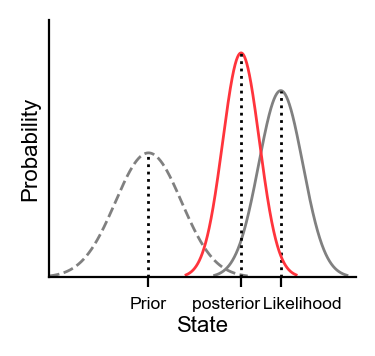

In [24]:
width = 1.7
height = 1.6

mus = [round(b_mean[0][0], 1) for b_mean in b_means]
sigmas = [np.sqrt(b_uncertain[0, 0]) for b_uncertain in b_uncertains]

xticklabels = ['Prior', '         Likelihood', 'posterior      ']
colors = ['gray', 'gray', belief_c]

with initiate_plot(width, height, 200) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(mus[:len(xticklabels)], xticklabels, fontsize=fontsize - 0.7)
    ax.axes.yaxis.set_ticks([])
    ax.set_xlabel('State', fontsize=fontsize + 1)
    ax.set_ylabel('Probability', fontsize=fontsize + 1)
    ax.set_xlim([-7.5, 6.4]); ax.set_ylim([0, 0.55])
    ax.yaxis.set_label_coords(-0.03, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)
    
    for idx, (mu, sigma) in enumerate(zip(mus, sigmas)):
        x_axis = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1001)
        prob = norm.pdf(x_axis, mu, sigma)
        ls = '--' if idx == 0 else '-'
        ax.plot(x_axis, prob, lw=lw, c=colors[idx], ls=ls, clip_on=False)
        if idx < 3:
            ax.plot(np.linspace(mu, mu), np.linspace(0, prob.max()), 
                    lw=lw, c='k', ls=':', clip_on=False)
    
    fig.tight_layout(pad=0.1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='belief_update'), orientation='portrait', format='pdf', transparent=True)

## 2b

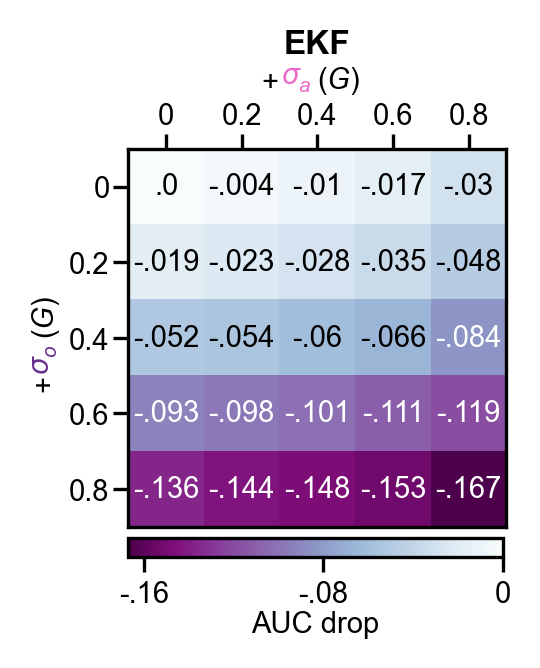

In [25]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_EKF_mean - auc_EKF_mean[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('EKF', fontsize=fontsize + 1, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.16, -0.08, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_EKF'), orientation='portrait', format='pdf', transparent=True)

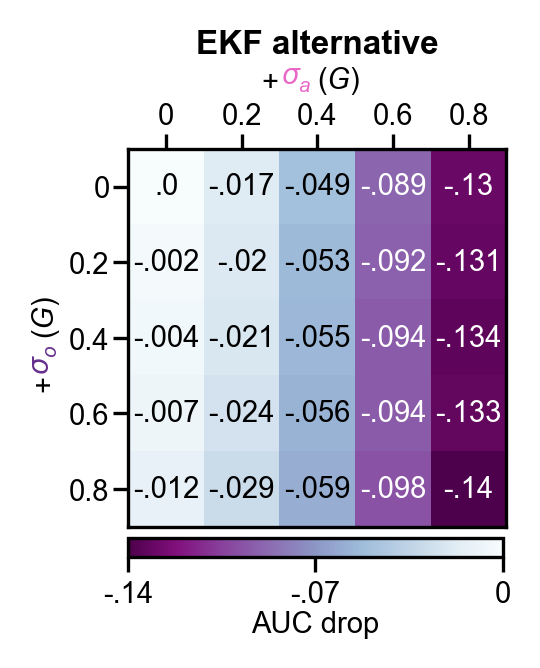

In [26]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_EKF_mean_control - auc_EKF_mean_control[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('EKF alternative', fontsize=fontsize + 1, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.14, -0.07, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_EKF_rev'), orientation='portrait', format='pdf', transparent=True)

## 2c

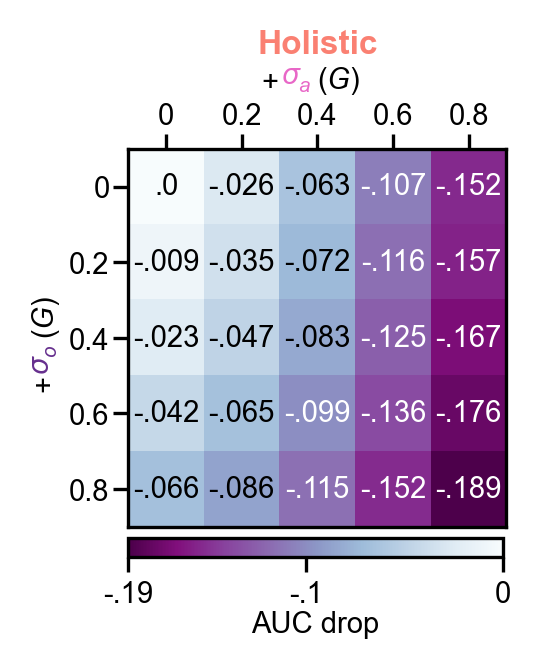

In [27]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_holistic_mean - auc_holistic_mean[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Holistic', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.19, -0.1, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_holistic'), orientation='portrait', format='pdf', transparent=True)

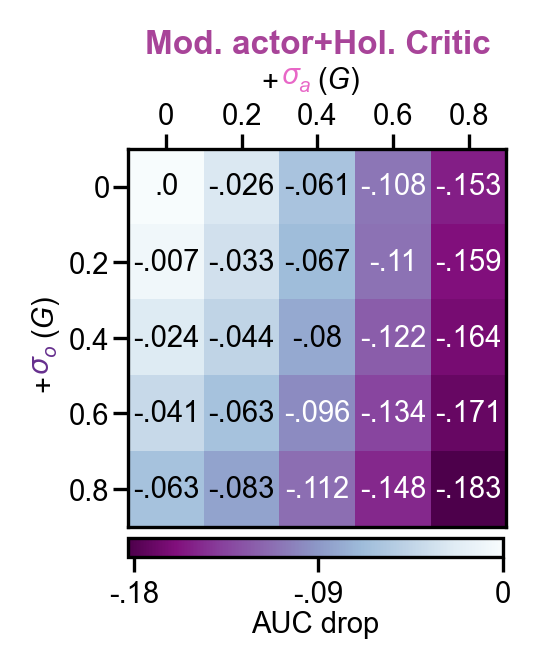

In [28]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_moho_mean - auc_moho_mean[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Mod. actor+Hol. Critic', fontsize=fontsize + 1, fontweight='bold', pad=3, c=moact_hocri_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.18, -0.09, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_moho'), orientation='portrait', format='pdf', transparent=True)

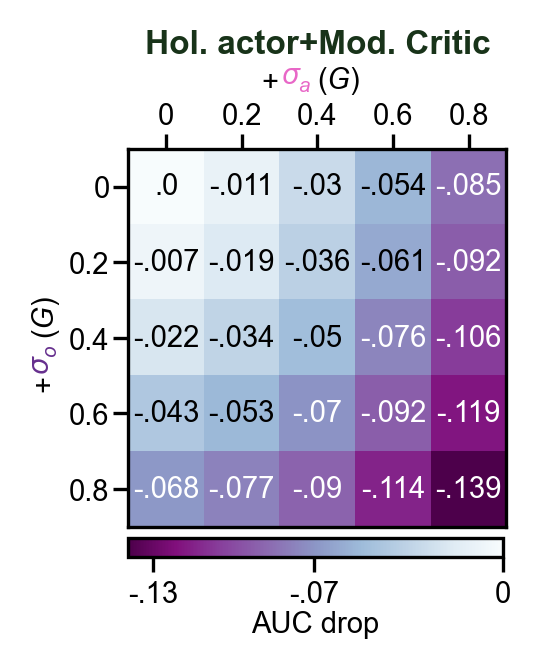

In [29]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_homo_mean - auc_homo_mean[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Hol. actor+Mod. Critic', fontsize=fontsize + 1, fontweight='bold', pad=3, c=hoact_mocri_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.13, -0.07, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_homo'), orientation='portrait', format='pdf', transparent=True)

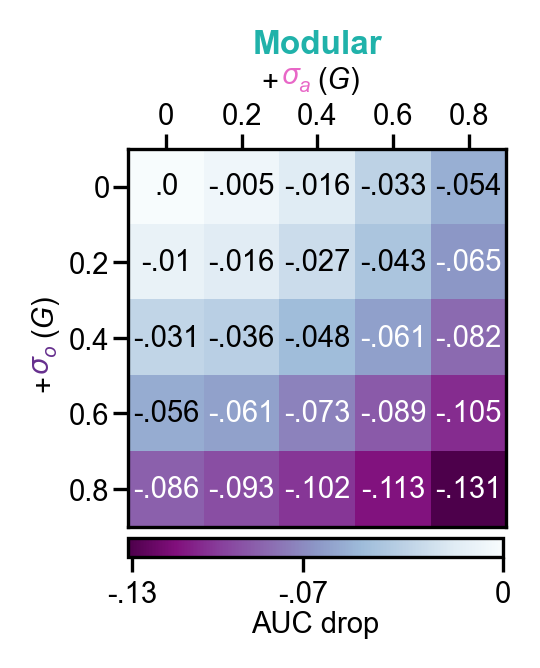

In [30]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_modular_mean - auc_modular_mean[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Modular', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.13, -0.07, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_modular'), orientation='portrait', format='pdf', transparent=True)

## S2b

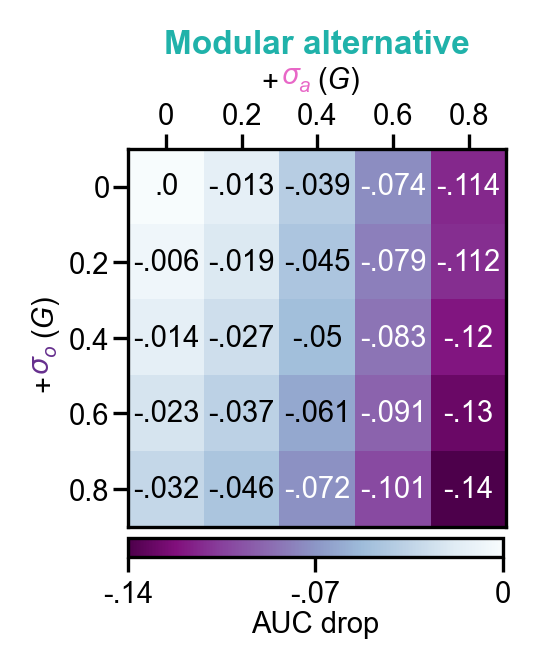

In [31]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_modular_mean_control - auc_modular_mean_control[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Modular alternative', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.14, -0.07, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_modular_rev'), orientation='portrait', format='pdf', transparent=True)

## S2c

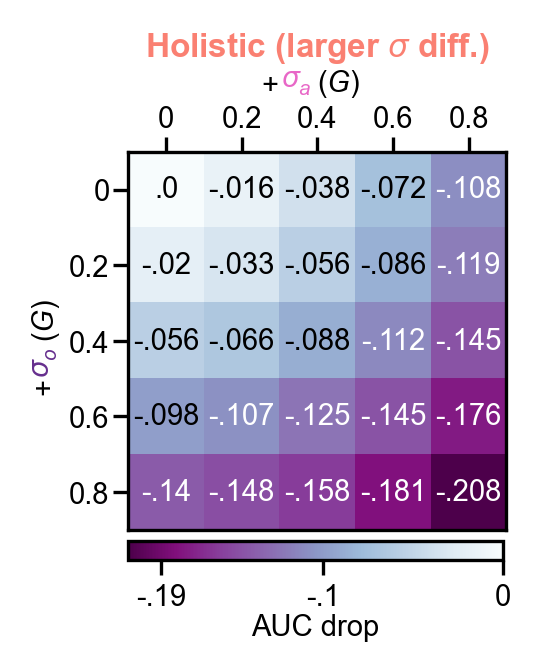

In [32]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_holistic_mean_control - auc_holistic_mean_control[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Holistic (larger $\sigma$ diff.)', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.19, -0.1, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_holisticS'), orientation='portrait', format='pdf', transparent=True)

## S2e

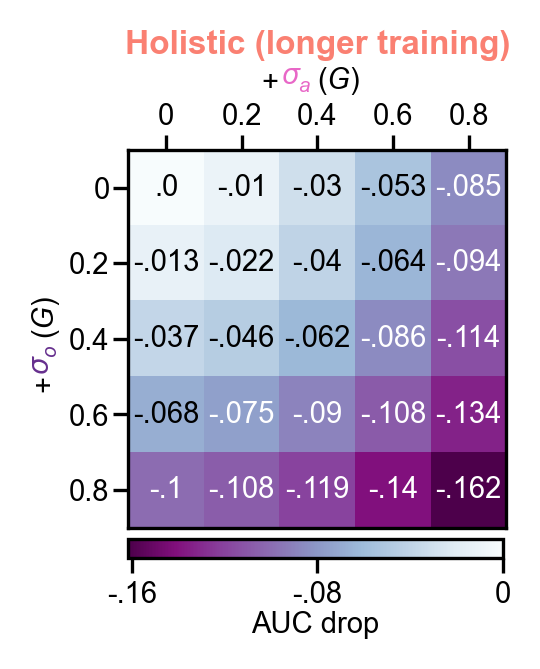

In [33]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_holistic_mean_long - auc_holistic_mean_long[0][0]

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Holistic (longer training)', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [-0.16, -0.08, 0]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC drop', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_holistic_longer'), orientation='portrait', format='pdf', transparent=True)

## S2g

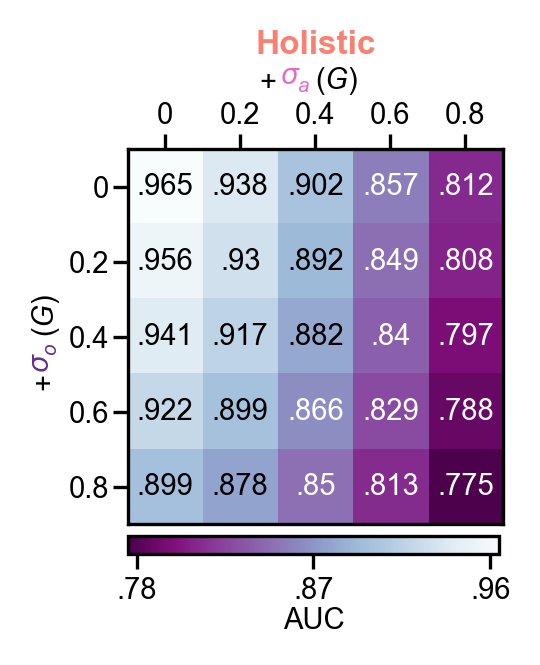

In [34]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_holistic_mean

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Holistic', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.78, 0.87, 0.96]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_holistic_abs'), orientation='portrait', format='pdf', transparent=True)

## S2h

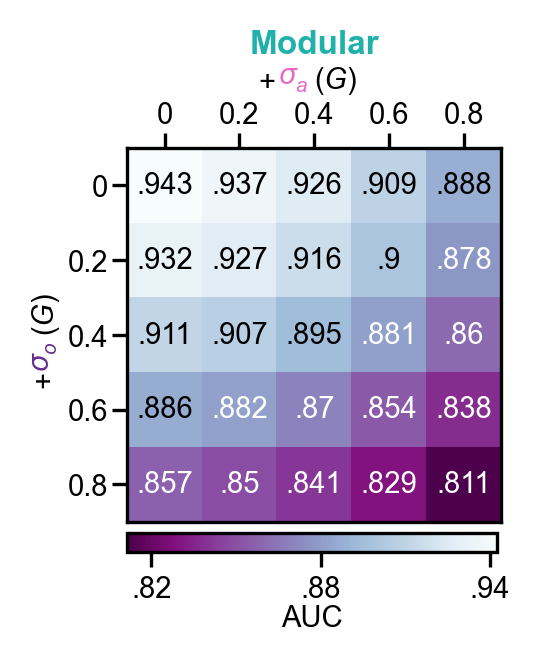

In [35]:
yticks = np.arange(len(obs_stds))
xticks = np.arange(len(pro_stds))
yticklabels = xticklabels = ['0', '0.2', '0.4', '0.6', '0.8']
width = 1.7
height = 2.2
values = auc_modular_mean

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Modular', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.22)
    ax.yaxis.set_label_coords(-0.18, 0.445)
        
    cmatplot = ax.matshow(values, cmap='BuPu_r') 
    ax.tick_params(axis='both', which='major', pad=1, bottom=False)
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.82, 0.88, 0.94]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.8)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(values[iy][ix], 3)
            c = 'k' if v > np.mean(values) else 'w'
            ax.text(x, y, s='.' + str(v).split('.')[1] if v>= 0 else '-.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(2, -1.3, '$(G)$', fontsize=fontsize)
    ax.text(1.25, -1.3, '$+$', fontsize=fontsize)
    ax.text(-1.8, 1.9, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.text(-1.8, 2.65, '$+$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_modular_abs'), orientation='portrait', format='pdf', transparent=True)

## S2i

MannwhitneyuResult(statistic=61.0, pvalue=0.0010878010878010878)


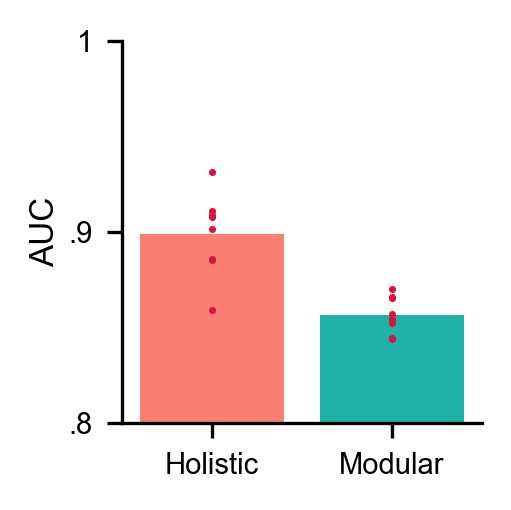

In [36]:
width = 1.5; height = 1.5
yticks = np.around(np.linspace(0.8, 1, 3), 1)
noise_idx = np.where(np.array(agent_noises) == '0.2_0.9')[0].item()
ydata = [auc_holistic[noise_idx], auc_modular[noise_idx]]
colors = [holistic_c, modular_c]

xticks = np.arange(2)
xticklabels = ['Holistic', 'Modular']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('AUC', fontsize=fontsize+1)
ax.set_xlabel(r'', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, y, c in zip(xticks, ydata, colors):
    ax.bar(x, np.mean(y), color=c)
    ax.scatter([x] * len(y), y, c='crimson', marker='.', s=2, lw=1, zorder=1)
    
print(mannwhitneyu(*ydata))

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='noise_2_9'), orientation='portrait', format='pdf', transparent=True)

## 2d

In [37]:
def my_pearsonr(x, y):
    return np.corrcoef(x, y)[0, 1]

In [39]:
corrs = []; corrs_shuffle = []
for data2 in [auc_holistic_mean, auc_moho_mean, auc_homo_mean, auc_modular_mean, auc_modular_mean_control]:
    data2 = data2.reshape(-1)
    data1 = auc_EKF_mean.reshape(-1)
    rng = np.random.default_rng(seed=0)
    data2_shuffle = data2.copy()
    rng.shuffle(data2_shuffle)
    
    res = bootstrap((data1, data2), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    res_shuffle = bootstrap((data1, data2_shuffle), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    
    corrs.append(res)
    corrs_shuffle.append(res_shuffle)

In [40]:
corrs_control = []; corrs_shuffle_control = []
for data2 in [auc_holistic_mean, auc_moho_mean, auc_homo_mean, auc_modular_mean, auc_modular_mean_control]:
    data2 = data2.reshape(-1)
    data1 = auc_EKF_mean_control.reshape(-1)
    rng = np.random.default_rng(seed=0)
    data2_shuffle = data2.copy()
    rng.shuffle(data2_shuffle)
    
    res = bootstrap((data1, data2), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    res_shuffle = bootstrap((data1, data2_shuffle), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    
    corrs_control.append(res)
    corrs_shuffle_control.append(res_shuffle)

In [41]:
corrs_control_holistic = []; corrs_shuffle_control_holistic = []
for data2 in [auc_holistic_mean, auc_holistic_mean_control]:
    data2 = data2.reshape(-1)
    data1 = auc_EKF_mean.reshape(-1)
    rng = np.random.default_rng(seed=0)
    data2_shuffle = data2.copy()
    rng.shuffle(data2_shuffle)
    
    res = bootstrap((data1, data2), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    res_shuffle = bootstrap((data1, data2_shuffle), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    
    corrs_control_holistic.append(res)
    corrs_shuffle_control_holistic.append(res_shuffle)

In [42]:
corrs_control_holistic_time = []; corrs_shuffle_control_holistic_time = []
for data2 in [auc_holistic_mean, auc_holistic_mean_long]:
    data2 = data2.reshape(-1)
    data1 = auc_EKF_mean.reshape(-1)
    rng = np.random.default_rng(seed=0)
    data2_shuffle = data2.copy()
    rng.shuffle(data2_shuffle)
    
    res = bootstrap((data1, data2), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    res_shuffle = bootstrap((data1, data2_shuffle), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    
    corrs_control_holistic_time.append(res)
    corrs_shuffle_control_holistic_time.append(res_shuffle)

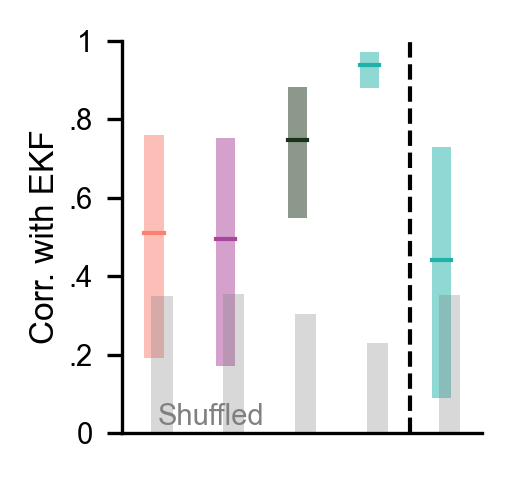

In [43]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0, 1, 6), 1)
ydata1 = corrs
ydata2 = corrs_shuffle
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, modular_c]

xticks = np.arange(5)
xticklabels = ['Ho', 'MoHo', 'HoMo', 'Mo', 'Mo (C)']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Corr. with EKF', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.2, x+0.075], [ymean, ymean], c=c, lw=lw)
    ax.fill_between([x-0.2, x+0.075], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5)

    
for x, ydata, c in zip(xticks, ydata2, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.1, x+0.2], [ymean, ymean], c='gray', lw=lw, ls='-')
    ax.fill_between([x-0.1, x+0.2], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor='gray', alpha=0.3)
    
    
ax.text(0, 0.02, 'Shuffled', fontsize=fontsize, c='gray')
ax.plot([3.5, 3.5], [0, 1], c='k', ls='--', lw=lw)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='corr_toEKF'), orientation='portrait', format='pdf', transparent=True)

## 2e

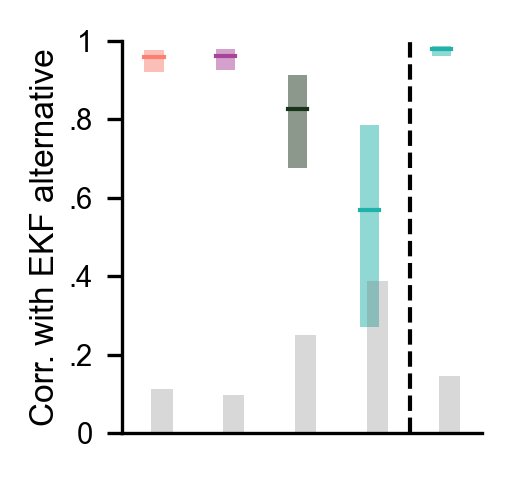

In [44]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0, 1, 6), 1)
ydata1 = corrs_control
ydata2 = corrs_shuffle_control
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, modular_c]

xticks = np.arange(5)
xticklabels = ['Ho', 'MoHo', 'HoMo', 'Mo', 'Mo (C)']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Corr. with EKF alternative', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.2, x+0.075], [ymean, ymean], c=c, lw=1)
    ax.fill_between([x-0.2, x+0.075], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5, clip_on=False)

    
for x, ydata, c in zip(xticks, ydata2, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.1, x+0.2], [ymean, ymean], c='gray', lw=1, ls='-')
    ax.fill_between([x-0.1, x+0.2], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor='gray', alpha=0.3)
    
ax.plot([3.5, 3.5], [0, 1], c='k', ls='--', lw=lw)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='corr_toEKFrev'), orientation='portrait', format='pdf', transparent=True)

## S2d

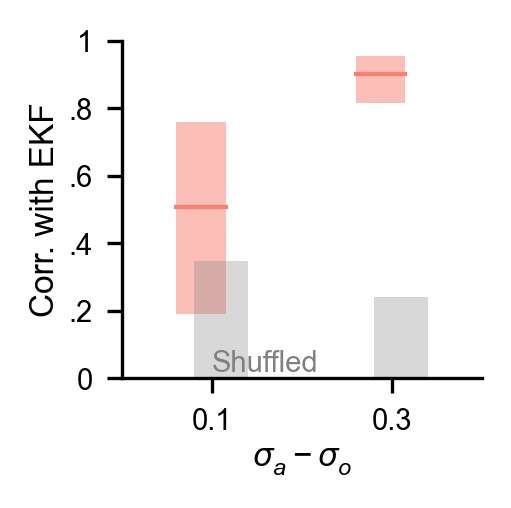

In [45]:
width = 1.5; height = 1.5
yticks = np.around(np.linspace(0, 1, 6), 1)
ydata1 = corrs_control_holistic
ydata2 = corrs_shuffle_control_holistic
colors = [holistic_c, holistic_c]

xticks = np.arange(2)
xticklabels = [0.1, 0.3]

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Corr. with EKF', fontsize=fontsize+1)
ax.set_xlabel(r'$\sigma_a-\sigma_o$', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.2, x+0.075], [ymean, ymean], c=c, lw=1)
    ax.fill_between([x-0.2, x+0.075], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5, clip_on=False)

    
for x, ydata, c in zip(xticks, ydata2, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.1, x+0.2], [ymean, ymean], c='gray', lw=1, ls='-')
    ax.fill_between([x-0.1, x+0.2], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor='gray', alpha=0.3)
    
    
ax.text(0, 0.02, 'Shuffled', fontsize=fontsize, c='gray')
ax.plot([3.5, 3.5], [0, 1], c='k', ls='--', lw=lw)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='corr_toEKF_holistic'), orientation='portrait', format='pdf', transparent=True)

## S2f

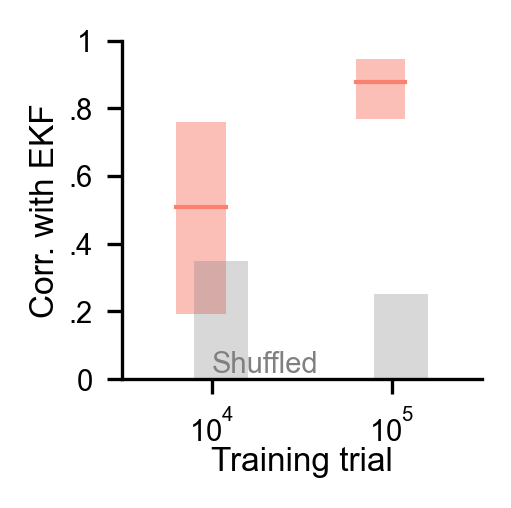

In [46]:
width = 1.5; height = 1.5
yticks = np.around(np.linspace(0, 1, 6), 1)
ydata1 = corrs_control_holistic_time
ydata2 = corrs_shuffle_control_holistic_time
colors = [holistic_c, holistic_c]

xticks = np.arange(2)
xticklabels = ['$10^4$', '$10^5$']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Corr. with EKF', fontsize=fontsize+1)
ax.set_xlabel('Training trial', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.2, x+0.075], [ymean, ymean], c=c, lw=1)
    ax.fill_between([x-0.2, x+0.075], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5, clip_on=False)

    
for x, ydata, c in zip(xticks, ydata2, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.1, x+0.2], [ymean, ymean], c='gray', lw=1, ls='-')
    ax.fill_between([x-0.1, x+0.2], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor='gray', alpha=0.3)
    
    
ax.text(0, 0.02, 'Shuffled', fontsize=fontsize, c='gray')
ax.plot([3.5, 3.5], [0, 1], c='k', ls='--', lw=lw)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='corr_toEKF_time'), orientation='portrait', format='pdf', transparent=True)